In [9]:
##step 1: importing 
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#load the dataset

df = pd.read_csv("../data/news.csv")

#inspect the dataset 

print ("shape: ", df.shape)
print ("Columns: ", df.columns)
df.head()

shape:  (6335, 4)
Columns:  Index(['Unnamed: 0', 'title', 'text', 'label'], dtype='object')


,Unnamed: 0,title,text,label
0,8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE
1,10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE
2,3608,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,REAL
3,10142,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",FAKE
4,875,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,REAL


In [10]:
df.drop(columns=['Unnamed: 0'], inplace=True)

#data gets encoded
encoder=LabelEncoder()
df['label']=encoder.fit_transform(df['label'])
#fit transform learns from the mapping and converts real to 1 and fake to 0

#check the result

print("Label Distribution:")
print(df['label'].value_counts())
df.head()

Label Distribution:
label
1    3171
0    3164
Name: count, dtype: int64


,title,text,label
0,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",0
1,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,0
2,Kerry to go to Paris in gesture of sympathy,U.S. Secretary of State John F. Kerry said Mon...,1
3,Bernie supporters on Twitter erupt in anger ag...,"— Kaydee King (@KaydeeKing) November 9, 2016 T...",0
4,The Battle of New York: Why This Primary Matters,It's primary day in New York and front-runners...,1


In [11]:
#configuration variables for preprocessing and model setup

embedding_dim=100
#size of word embedding vectors, each word is represented as a 100-d vector in embedding layer to capture more nuance

max_length=100
#max length of input sequence (number of tokens per headline)  headlines longer than 100 words cutoff, short ones will be padded so that each input has same length

trunc_type='post'
#if text > max_length, trunc from end, 'pre' would mean from begining

padding_type='post'
#if text <max_length, pad 0's at th end

oov_tok="<OOV>" 
#token used for words not in the vocabulary, any word not seen in tarining replaced by this to prevent errors in case of new words

training_portion=0.8
#80% data used for training


In [12]:
#step 8: tokenization, bridging the gap between human words and machine language models

titles=df['title'].values #extract the titles as input a numpy array
tokenizer=Tokenizer(oov_token=oov_tok) #initialize the tokenizer , an object created
tokenizer.fit_on_texts(titles) #place titles on it, creates mapping, creates vocabulary
sequences=tokenizer.texts_to_sequences(titles) #convert titles to sequence of integers
padded=pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print("Vocabulary size:", len(tokenizer.word_index))
print("Shape of padded sequences:", padded.shape)

Vocabulary size: 11722
Shape of padded sequences: (6335, 100)


In [13]:
#step 9: train/test split

labels=df['label'].values
train_size=int(len(padded)*training_portion) #calculated the index where split has to happen

#split padded sequences
train_sequences=padded[:train_size] #takes first 80% of the array
test_sequences=padded[train_size:]

#split labels
train_labels=labels[:train_size]
test_labels=labels[train_size:]

print("training samples:", len(train_sequences))
print("testing samples:",  len(test_sequences))


training samples: 5068
testing samples: 1267


In [14]:
#step 10: convert sequences and labels to numpy arrays

train_sequences=np.array(train_sequences)
train_labels=np.array(train_labels)
test_sequences=np.array(test_sequences)
test_labels=np.array(test_labels)

print("Train sequence shape: ",train_sequences.shape)
print("Test sequence shape: ",test_sequences.shape)

Train sequence shape:  (5068, 100)
Test sequence shape:  (1267, 100)


In [15]:
#step 11: load GloVe embeddings

embedding_index={}
#will do word->pretrained vector
with open ("../data/glove.6B.100d.txt",encoding="utf8")as f:
    for line in f:#each line=1 word and 100 float numbers
        values=line.split()
        word=values[0]
        coefs=np.asarray(values[1:],dtype='float32') #remaining strings converted to a float32 np array, 100d embedding vector
        embedding_index[word]=coefs #word is key, coefs is value
print("Loaded word vectors:",len(embedding_index))

#create embedding matrix
vocab_size=len(tokenizer.word_index)+1 #reserves index 0
embedding_matrix=np.zeros((vocab_size, embedding_dim)) #2d matrix of zeros, 1 ro/vocab index and 1 col/embedding dim

for word,i in tokenizer.word_index.items():
    embedding_vector=embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i]=embedding_vector

print("Embedding matrix shape:",embedding_matrix.shape)

    

Loaded word vectors: 400000
Embedding matrix shape: (11723, 100)


In [37]:
#building the model Embedding +LSTM + dense with sigmoid
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

model = Sequential() #creating a linear stack of layers

#Embedding layer using GloVe matrix
model.add(Embedding( #i/p is word IDs, o/p their glov evectors 
    input_dim=vocab_size, #number of words in tokenizer vocab
    output_dim=embedding_dim, #size of each embedding vector (100)
    weights=[embedding_matrix], #pretrained GloVe vectors
    input_length=max_length, #length of padded sequences (100)
    trainable=True # false keep embeddings fixed (not updated during training), true for fine tuning
)) #the bridge from tokens to semantic vectors

#LSTM layer for sequence learning
from tensorflow.keras.layers import LSTM, GlobalMaxPooling1D
model.add(LSTM(64,return_sequences=True)) #learns sequence patterns
model.add(GlobalMaxPooling1D()) #reduces sequence output to most important features

#dropout for regularization
model.add(Dropout(0.6)) #drops 50% of connections during training

#dense output layer with sigmoid activation
#also adding l2 regularization
from tensorflow.keras import regularizers
model.add(Dense( 
    1, 
    activation='sigmoid', 
    kernel_regularizer=regularizers.l2(0.01) 
))

#Compile the model and import adam
from tensorflow.keras.optimizers import Adam
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='binary_crossentropy',
    
    metrics=['accuracy'])
#2-class problems, adaptive, track performance

model.summary()



Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ ?                           │       1,172,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_9 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_5               │ ?                           │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,172,300 (4.47 MB)

 Trainable params: 1,172,300 (4.47 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
#train the model
# Step 13: Train the model 
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(
    monitor='val_loss',
    patience=2,
    restore_best_weights=True
)
history = model.fit( train_sequences, train_labels, # training data 
                     epochs=10, # number of passes through the dataset
                     batch_size=32, # headlines per update 
                     validation_data=(test_sequences, test_labels), # monitor performance on unseen data
                    callbacks=[early_stop]  
                   )



Epoch 1/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step - accuracy: 0.8717 - loss: 0.3391 - val_accuracy: 0.7916 - val_loss: 0.5026
Epoch 2/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 10s 60ms/step - accuracy: 0.9108 - loss: 0.2666 - val_accuracy: 0.7893 - val_loss: 0.5736
Epoch 3/10
159/159 ━━━━━━━━━━━━━━━━━━━━ 9s 59ms/step - accuracy: 0.9155 - loss: 0.2754 - val_accuracy: 0.6551 - val_loss: 1.0711


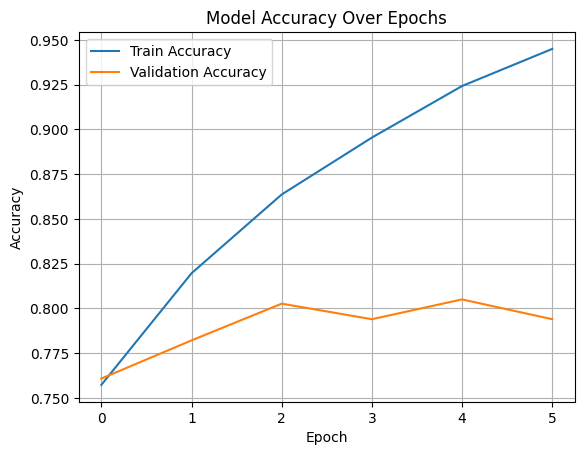

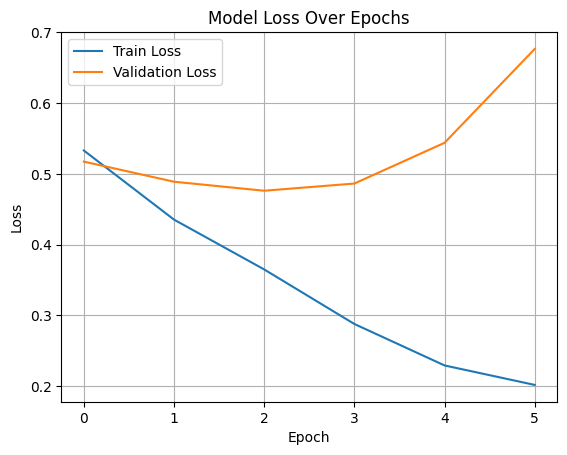

In [47]:
#step13: plotting the results...
import matplotlib.pyplot as plt

#accuracy plot
plt.plot(history.history['accuracy'],label='Train Accuracy')
plt.plot(history.history['val_accuracy'],label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
         
#oss plot 
plt.plot(history.history['loss'], label='Train Loss') 
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs') 
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend() 
plt.grid(True)
plt.show()  

In [50]:
model.save('fake_news_model_best.keras')

In [53]:
#step 14: sample prediction (deployment check)
import pickle # Save tokenizer to file
with open('tokenizer.pkl', 'wb') as f: 
    pickle.dump(tokenizer, f)

# Load tokenizer from file 
with open('tokenizer.pkl', 'rb') as f: 
    tokenizer = pickle.load(f)
    
from tensorflow.keras.models import load_model
import numpy as np

#load the best model
model = load_model('fake_news_model_best.keras')

#example headlines
sample_headlines = [
    "Breaking: Scientists discover cure for cancer",
    "Celebrity spotted on Mars in shocking photos"
]

#convert to padded sequences
sample_sequences=tokenizer.texts_to_sequences(sample_headlines)
sample_padded=pad_sequences(sample_sequences, maxlen=max_length)

predictions = model.predict(sample_padded)

for h, p in zip(sample_headlines, predictions):
    print(f"Headline: {h}")
    print(f"Prediction: {'REAL' if p>0.5 else 'FAKE'} (score={p[0]:.4f})\n")
    

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Headline: Breaking: Scientists discover cure for cancer
Prediction: FAKE (score=0.4615)

Headline: Celebrity spotted on Mars in shocking photos
Prediction: FAKE (score=0.4896)

